# **Detecção de covid-19**

In [ ]:
# Autoriza conexão com o drive
# Faça o upload de um dataset contendo as pastas "Normal" e "COVID" e suas respectivas imagens 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carregar bibliotecas 

In [ ]:
# Desativa todos os warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Leitura dos dados
import os
from glob import glob
from PIL import Image

# Processamento dos dados 
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A

# Analise dos dados
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem de dados
# Avaliação de modelos
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score


# Leitura dos dados

In [ ]:
levels = ['Normal', 'COVID']
path = "../content/drive/MyDrive/covid-19_imagens2"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})
samples = 2000

data.head()

,image_file,corona_result,path
0,Normal/Normal-10052.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...
1,Normal/Normal-1089.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...
2,Normal/Normal-1203.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...
3,Normal/Normal-10009.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...
4,Normal/Normal-1137.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...


# Explorando os dados

### 1. Contador de dados (mostra a quantidade de imagens pra cada classe)

In [ ]:
df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["orange", "purple"],
             template = 'plotly_dark')

fig.update_xaxes(showgrid = False)
fig.update_yaxes(showgrid = False)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()

### 2. Amostra de imagens (apresenta 3 imagens de cada classe)

In [ ]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,Normal/Normal-10052.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...,"[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4,..."
1,Normal/Normal-1089.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...,"[[107, 171, 149, 144, 164, 134, 89, 88, 92, 93..."
2,Normal/Normal-1203.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...,"[[11, 30, 50, 69, 86, 94, 95, 95, 137, 126, 12..."
3,Normal/Normal-10009.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...,"[[202, 170, 156, 153, 151, 149, 148, 147, 147,..."
4,Normal/Normal-1137.png,Negative,../content/drive/MyDrive/covid-19_imagens2/Nor...,"[[7, 20, 33, 46, 59, 74, 77, 85, 89, 85, 115, ..."


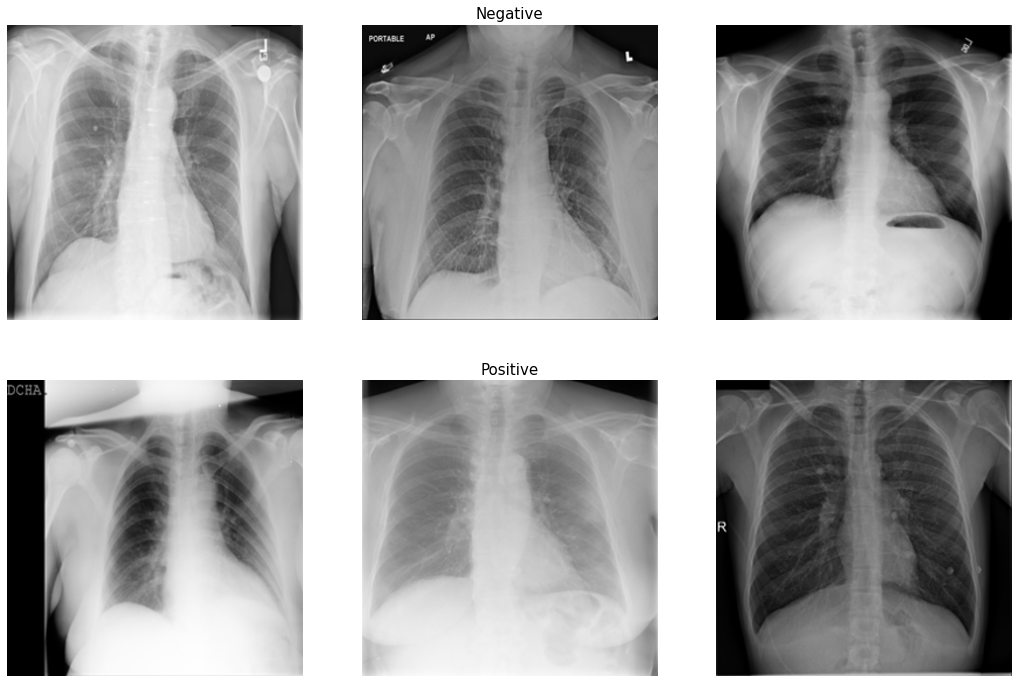

In [ ]:
n_samples = 3

fig, m_axs = plt.subplots(2, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 15)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

### 3. Exibir metadados de uma imagem aleatória

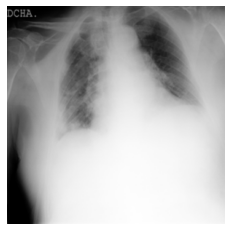

In [ ]:
plt.figure()
image = cv2.imread("/content/drive/MyDrive/covid-19_imagens2/COVID/COVID-324.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [ ]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


# Data Modeling 

### Train Test Split 

In [ ]:
all_data = []

# Storing images and their labels into a list for further Train Test split

for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [ ]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1280, 70, 70, 3) (400, 70, 70, 3) (1280,) (400,)


### CNN Model

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 128, activation = 'relu'))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 34, 34, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 34, 34, 128)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 16, 16, 64)      

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 200)

#tf.random.set_seed(42)
history = cnn_model.fit(x_train, y_train, 
                        epochs = 100, batch_size = 256,  
                        validation_data = (x_test, y_test), 
                        callbacks = [es])

Epoch 1/100
5/5 [==============================] - 1s 133ms/step - loss: 0.6478 - accuracy: 0.6313 - val_loss: 0.6318 - val_accuracy: 0.6350
Epoch 2/100
5/5 [==============================] - 1s 118ms/step - loss: 0.6175 - accuracy: 0.6438 - val_loss: 0.6099 - val_accuracy: 0.7100
Epoch 3/100
5/5 [==============================] - 1s 120ms/step - loss: 0.6014 - accuracy: 0.6734 - val_loss: 0.6404 - val_accuracy: 0.5950
Epoch 4/100
5/5 [==============================] - 1s 118ms/step - loss: 0.5853 - accuracy: 0.6758 - val_loss: 0.5911 - val_accuracy: 0.6900
Epoch 5/100
5/5 [==============================] - 1s 122ms/step - loss: 0.5684 - accuracy: 0.6852 - val_loss: 0.5817 - val_accuracy: 0.7075
Epoch 6/100
5/5 [==============================] - 1s 121ms/step - loss: 0.5612 - accuracy: 0.6867 - val_loss: 0.5900 - val_accuracy: 0.6950
Epoch 7/100
5/5 [==============================] - 1s 119ms/step - loss: 0.5460 - accuracy: 0.7063 - val_loss: 0.5752 - val_accuracy: 0.7125
Epoch 8/100
5

In [ ]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

### Model Evaluation

In [ ]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------".format(name))
    
    cm_test = confusion_matrix(y_test, yp_test)
    t1 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nResultados para os dados de treinamento\n")
    #print(classification_report(y_test, yp_test))   
    #print("--------------------------------------------------------------------------")
    print("Recall: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity: ", s3)
    print("Accuracy: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
       
    t1.plot()


-----------------------------Rede Neural Convolucional-----------------------------

Resultados para os dados de treinamento

Recall:  0.8458
Specificity:  0.8894
Accuracy:  0.8675
Precision:  0.8854
F1 Score:  0.8651
--------------------------------------------------------------------------


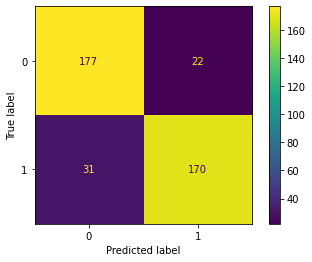

In [ ]:
evaluation_parametrics("Rede Neural Convolucional", y_train, yp_train, y_val, yp_val, y_test, yp_test)

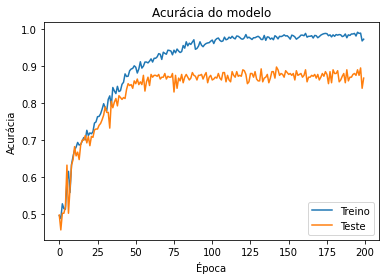

In [ ]:
# Gráfico de acurácia

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc = 'lower right')
plt.show()

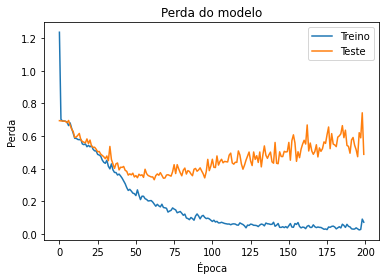

In [ ]:
# Gráfico de loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc = 'upper right')
plt.show()